In [1]:
# This cell is included to show what libraries are imported and used in the project
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import sys
import os
import pickle
import math
import pymc3
import itertools
import seaborn as sns

from glob import glob
from scipy.linalg import expm
import bisect
from numpy import linalg as LA

import tensorflow as tf

from sklearn.decomposition import PCA

from IPython.display import HTML
%matplotlib inline

In [2]:
# Functions that perform a random transformation (Based on Freifeld article)

# Generate L matrix from eq. 10
def generate_L(N_p):
    rows = N_p - 1
    cols = 2 * N_p
    
    delta = float(1 / N_p)
    
    L = np.zeros((rows, cols))
    
    for i in range(rows):
        L[i][2*i] = (i+1) * delta
        L[i][2*i+1] = 1
        L[i][2*i+2] = -(i+1) * delta
        L[i][2*i+3] = -1
    
    return L


# Find basis of null space of matrix via SVD
def nullspace(A, atol=1e-16, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

# Psi computation, Eq. 20 in Freifeld
def psi_computation(x, a, b, t):
    if a == 0:
        psi = x + t*b
    else:
        psi = math.exp(t*a)*x + (b*(math.exp(t*a)-1))/a
    
    return psi

# Transformation v1! (Algorithm 1 from Freifeld)
def transformation_v1(P, A, U, N_step, N_p, t=1):
    N_pts = len(U)
    delta_t = float(t) / N_step
    
    phi = np.zeros(N_pts)
    
    for i in range(N_pts):
        phi[i] = U[i]
        
        for j in range(N_step):
            c = bisect.bisect_left(P[1:], phi[i])
            if c == N_p:
                c = c-1
            a = A[2*c]
            b = A[2*c+1]

            phi[i] = psi_computation(phi[i], a, b, delta_t)
        
    return phi


# Perform data augmentation
def generate_new_data(sigma, B, X_train, N_step, N_p):
    [D,d] = B.shape
    [train_size,ts_length] = X_train.shape
    
    # Sample new transformation from Gaussian distribution
    theta_new = np.random.multivariate_normal(mean=np.zeros(d), cov=sigma)

    # Compute A matrix for new transformation
    A = np.matmul(B, theta_new)

    # Sample a data point from uniform distribution
    i = random.randint(0, train_size-1)
    x_i = X_train[i]

    # Transform time series
    x = np.linspace(0,1,ts_length)
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    T_x_i = np.interp(x, x_trans_resc, x_i)
    
    return T_x_i


def remove_outliers_1d(data):
    # Find mean and standard deviation
    sd = np.std(data)
    mean = np.mean(data)
    
    # Find indices for data points to be removed
    indices = []
    for i in range(len(data)):
        if (data[i] < mean - 3*sd or mean + 3*sd < data[i]):
            indices.append(i)
            
    # Remove outliers
    return np.delete(data, indices)


def remove_outliers(data):
    # Compute norm of every data point
    data_norm = LA.norm(data, axis=1)
    
    # Find mean and standard deviation
    sd = np.std(data_norm)
    mean = np.mean(data_norm)
    
    # Find indices for data points to be removed
    indices = []
    for i in range(len(data)):
        if (data_norm[i] < mean - 3*sd or mean + 3*sd < data_norm[i]):
            indices.append(i)
            
    # Remove outliers
    return np.delete(data, indices, axis=0)


# ------------------------------- Functions for Tensorflow -------------------------------
# Transformation v2! (TENSORFLOW IMPLEMENTATION)
def transformation_v2(A, U, N_step, N_p, t=1):
    delta_t = float(t) / N_step
    
    phi = U
    
    for j in range(N_step):
        
        # Find cell index
        idx = tf.floor(N_p * phi)
        idx = tf.clip_by_value(idx, clip_value_min=0, clip_value_max=N_p-1)
        idx = tf.cast(idx, tf.int32)
        
        # Fetch values from A (vector field)
        a = tf.reshape(tf.gather(A, 2*idx), [-1])
        b = tf.reshape(tf.gather(A, 2*idx+1), [-1])
        
        # Perform psi computation
        phi = tf.where(tf.equal(a, 0), psi_a_eq_zero(phi, a, b, delta_t), psi_a_noteq_zero(phi, a, b, delta_t))
        
    return phi

def psi_a_eq_zero(x, a, b, t):
    tb = tf.multiply(t,b)
    psi = tf.add(x, tb)
    return psi

def psi_a_noteq_zero(x, a, b, t):
    c1 = tf.exp(tf.multiply(t, a))
    c2 = tf.truediv(tf.multiply(b, tf.subtract(c1, 1)), a)
    psi = tf.add(tf.multiply(c1, x), c2)
    return psi

def tf_linear_interpolation(x, x_trans, y, ts_length):
    
    # POSSIBLY RESCALE VALUES IN X_TRANS TO RANGE [0,1] !!!!!!!!!!!!!
    
    # Find nearest smaller neighbor
    dist = tf.subtract(tf.reshape(x_trans, [-1, 1]), x)
    
    # Find index of interval in tessellation
    greater_than_zero = tf.greater_equal(dist, 0)
    idx = (ts_length-1) - tf.reduce_sum(tf.cast(greater_than_zero, tf.float32), axis=0)
    idx = tf.clip_by_value(idx, clip_value_min=0, clip_value_max=ts_length-2)
    idx = tf.cast(idx, tf.int32)
    
    # Fetch values from x_trans and y
    x0 = tf.gather(x_trans, idx)
    x1 = tf.gather(x_trans, idx+1)
    y0 = tf.gather(y, idx)
    y1 = tf.gather(y, idx+1)
    
    # Perform linear interpolation on points in x
    #frac = tf.truediv(tf.subtract(y1, y0), tf.subtract(x1, x0))
    #x_diff = tf.subtract(x, x0)
    #y_interp = tf.add(y0, tf.multiply(x_diff, frac))
    
    y_interp = y0 + (x-x0) * ((y1-y0)/(x1-x0))
    
    return y_interp

In [3]:
PATH = 'UCR_TS_Archive_2015/'
data_sets = {}

In [150]:
ds = 'Herring'

for folder_PATH in glob(PATH+'*/'):
    
    #ds = folder_PATH.split("/")[-2]
    if ds != folder_PATH.split("/")[-2]:
        continue
    data_sets[ds] = {}
    
    print(ds)
    
    with open(folder_PATH + ds + '_TRAIN', 'r') as f:
        
        train = f.read().splitlines()
        data_sets[ds]['TRAIN'] = np.array([train[0].split(",")])
        
        for line in train[1:]:
            data_sets[ds]['TRAIN'] = np.append(data_sets[ds]['TRAIN'], [line.split(",")], axis=0)
            
    with open(folder_PATH + ds + '_TEST', 'r') as f:
        
        test = f.read().splitlines()
        data_sets[ds]['TEST'] = np.array([test[0].split(",")])
        
        for line in test[1:]:
            data_sets[ds]['TEST'] = np.append(data_sets[ds]['TEST'], [line.split(",")], axis=0)

Herring


In [151]:
# Set up training and test set
train_size = len(data_sets[ds]['TRAIN'])
test_size = len(data_sets[ds]['TEST'])
ts_length = len(data_sets[ds]['TRAIN'][0])-1

X_train = np.zeros((train_size, ts_length))
y_train = np.zeros(train_size)

X_test = np.zeros((test_size, ts_length))
y_test = np.zeros(test_size)

for i in range(ts_length+1):
    # Train
    for j in range(train_size):
        if i == 0:
            y_train[j] = int(data_sets[ds]['TRAIN'][j][0])
        else:
            X_train[j][i-1] = float(data_sets[ds]['TRAIN'][j][i])
    # Test
    for j in range(test_size):
        if i == 0:
            y_test[j] = int(data_sets[ds]['TEST'][j][0])
        else:
            X_test[j][i-1] = float(data_sets[ds]['TEST'][j][i])
            
if not np.all(y_train):
    zero_idx = True
else:
    zero_idx = False
            
# Make sure the labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Make sure the labels are zero indexed
num_classes = len(np.unique(y_train))

idx = 0
for label in np.unique(y_train):
    y_train[np.where( y_train == label )] = idx
    y_test[np.where( y_test == label )] = idx
    idx += 1
    
# Convert labels to one-hot encoding
y_train_onehot = np.zeros((train_size, num_classes))
y_train_onehot[np.arange(train_size), y_train] = 1

In [152]:
y_train

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0])

Text(0.5,1,'Before transformation')

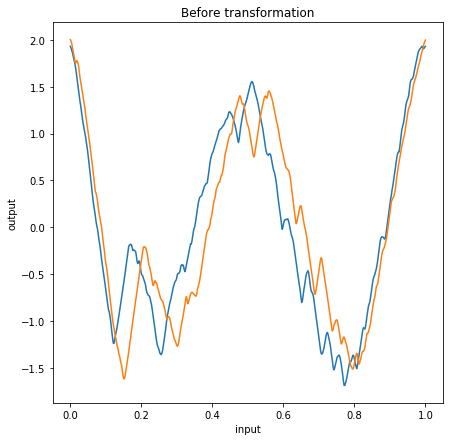

In [153]:
# Plot two selected time series
n = 0
m = 4
plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0,1,ts_length), X_train[n], np.linspace(0,1,ts_length), X_train[m])
plt.xlabel('input')
plt.ylabel('output')
plt.title('Before transformation')

In [154]:
# Get indices for different classes
class_indices = {}

for label in range(num_classes):
    class_indices[label] = np.where( y_train == label )[0]
    
print(class_indices[0])
print(class_indices[1])

# Get pairs of indices for transformations
transformations_pairs = []

for label in range(num_classes):
    for n in range(train_size):
        for m in range(train_size):
            if n in class_indices[label] and m in class_indices[label]:
                transformations_pairs.append((n,m))

[ 0  1  3  4  6  7 10 11 12 15 17 20 22 23 24 26 27 29 30 31 32 35 36 37 39
 40 41 42 44 46 50 52 53 54 57 58 59 60 63]
[ 2  5  8  9 13 14 16 18 19 21 25 28 33 34 38 43 45 47 48 49 51 55 56 61 62]


In [155]:
with open('transformations/' + ds + '_transformations', 'rb') as f:
    ds_transformations_pkl = pickle.load(f)
    
print(ds_transformations_pkl)

[[  3.61771835e-10   1.39440317e-08  -6.48906839e-09 ...,   1.72017167e-09
    1.15457111e-09   1.27174504e-09]
 [  1.22686918e-03  -4.38371338e-02   5.31591587e-02 ...,   2.23298684e-01
   -7.54102767e-02   6.88072816e-02]
 [  2.82366155e-03  -8.63601938e-02   9.25607160e-02 ...,  -5.91538241e-03
    5.10021113e-03   4.28312905e-02]
 ..., 
 [  3.24819461e-02  -1.48907289e-01  -1.35696097e-03 ...,   1.88290700e-01
   -6.07141070e-02  -6.34248182e-02]
 [ -4.34117727e-02   3.19896787e-02   4.71990369e-03 ...,  -2.85780914e-02
    2.19088160e-02   3.42641957e-03]
 [  3.46678075e-10   1.70183714e-10   1.26667468e-10 ...,  -1.86454407e-10
   -3.75521253e-10  -4.28356794e-10]]


In [156]:
print(len(transformations_pairs))
print(len(ds_transformations_pkl))

2146
2146


In [157]:
# Seperate transformations into classes
split_indices = []

for i in range(num_classes):
    split_indices.append(len(class_indices[i])**2)
    
split_indices = np.cumsum(split_indices)[:-1]

theta_classes = np.split(ds_transformations_pkl, split_indices)

In [158]:
# Clean set of transformations

# Remove NaNs
for i in range(num_classes):
    print(len(theta_classes[i]))
    theta_classes[i] = theta_classes[i][~np.isnan(theta_classes[i]).any(axis=1)]
    print(len(theta_classes[i]))

1521
1505
625
619


In [159]:
# Choose which class to examine
class_idx = 0

thetas = theta_classes[class_idx]

# Remove outliers
thetas = remove_outliers(thetas)

In [160]:
# Perform principal component analysis/singular value decomposition
pca = PCA(n_components=None)
pca.fit(thetas)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## Plot transformations of a data point

In [161]:
# Choose which class to examine
class_idx = 1

thetas = theta_classes[class_idx]

# Remove outliers
thetas = remove_outliers(thetas)

# Perform principal component analysis/singular value decomposition
pca = PCA(n_components=None)
pca.fit(thetas)

# Get covariance
sigma = pca.get_covariance()

# Extract data points from chosen class
X_train_class = X_train[np.where( y_train == class_idx )]
class_size = len(X_train_class)

In [162]:
# Number of intervals and number of cell intersections
N_p = 10
N_v = N_p + 1

N_step = 100

# Generate tesselation in 1D
tess = np.linspace(0,1,N_v)

# Generate L
L = generate_L(N_p)

# Find basis for null(L)
B = nullspace(L)
[D,d] = B.shape

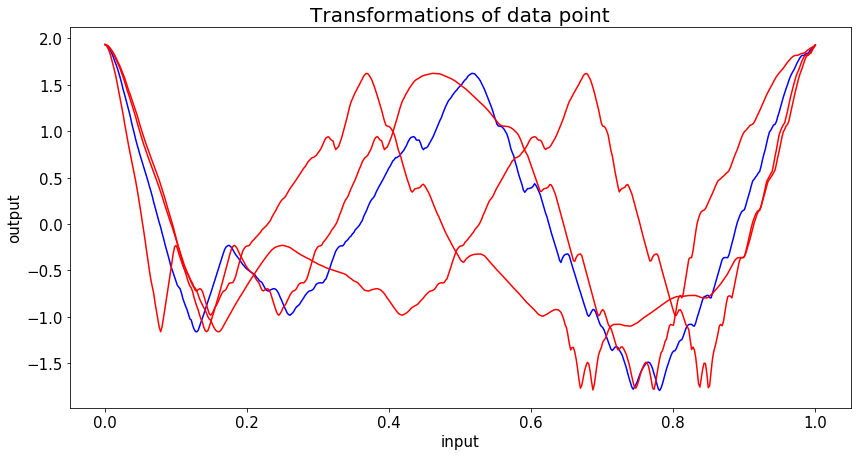

In [163]:
# Plot data point and its transformations

# Sample a data point
x = np.linspace(0,1,ts_length)
data_point = X_train[11]
# Sample a data point from uniform distribution
#i = random.randint(0, class_size-1)
#data_point = X_train_class[i]



plt.figure(figsize=(14, 7))
plt.plot(x, data_point, color='b', linewidth=1.5)
plt.xlabel('input', fontsize=15)
plt.ylabel('output', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Transformations of data point', fontsize=20)


for trans_i in range(3):
    # Sample new transformation from Gaussian distribution
    theta_new = np.random.multivariate_normal(mean=np.zeros(d), cov=sigma)

    # Compute A matrix for new transformation
    A = np.matmul(B, theta_new)

    # Transform time series
    x = np.linspace(0,1,ts_length)
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    T_data_point = np.interp(x, x_trans_resc, data_point)
    
    
    plt.plot(x, T_data_point, color='r', linewidth=1.5)
          
#plt.savefig("generated_data_combined.eps", bbox_inches='tight')
plt.show()

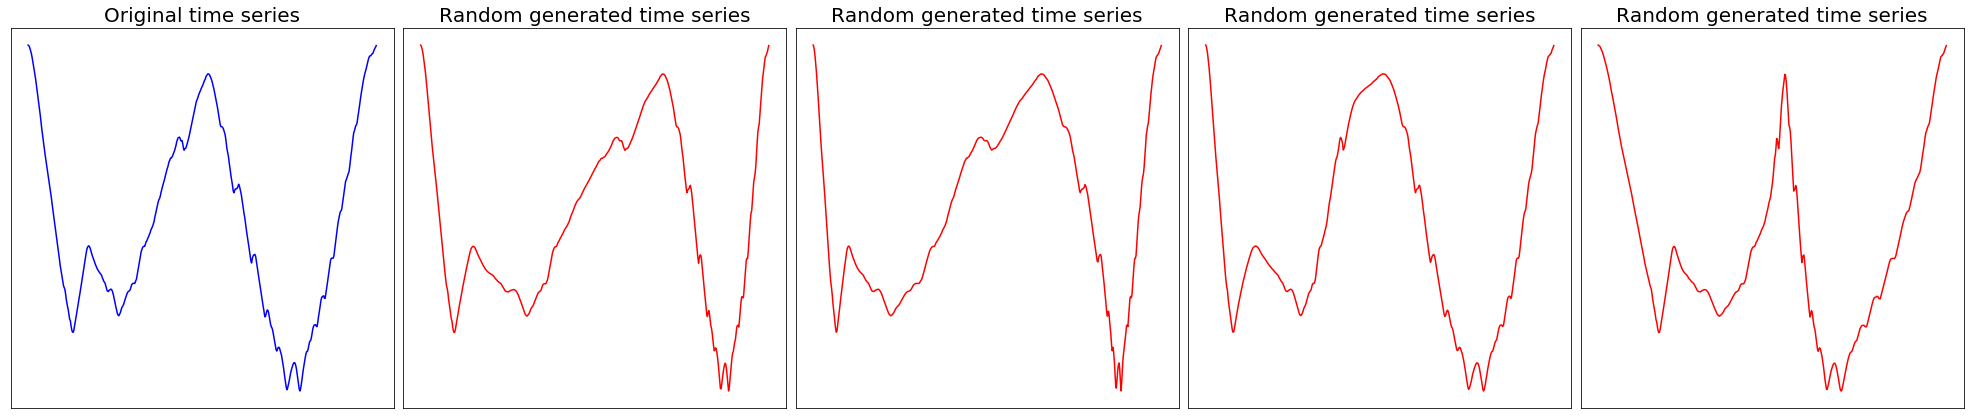

In [164]:
# Plot data point and its transformations

# Sample a data point
x = np.linspace(0,1,ts_length)
data_point = X_train[11]
# Sample a data point from uniform distribution
#i = random.randint(0, class_size-1)
#data_point = X_train_class[i]



title_size = 20
plt.figure(figsize=(35, 7))

plt.subplot(151)
plt.plot(x, data_point, color='b', linewidth=1.5)
plt.title('Original time series', fontsize=title_size)
plt.xticks([])
plt.yticks([])


for trans_i in range(4):
    # Sample new transformation from Gaussian distribution
    theta_new = np.random.multivariate_normal(mean=np.zeros(d), cov=sigma)

    # Compute A matrix for new transformation
    A = np.matmul(B, theta_new)

    # Transform time series
    x = np.linspace(0,1,ts_length)
    x_trans = transformation_v1(tess, A, x, N_step, N_p)

    # Interpolate values to correct interval
    x_trans_resc = (x_trans - np.amin(x_trans)) / (np.amax(x_trans) - np.amin(x_trans))
    T_data_point = np.interp(x, x_trans_resc, data_point)
    
    plt.subplot(152 + trans_i)
    plt.plot(x, T_data_point, color='r', linewidth=1.5)
    plt.title('Random generated time series', fontsize=title_size)
    plt.xticks([])
    plt.yticks([])
          
plt.subplots_adjust(wspace=0.025, hspace=0)

#plt.savefig("generated_data.eps", bbox_inches='tight')
plt.show()

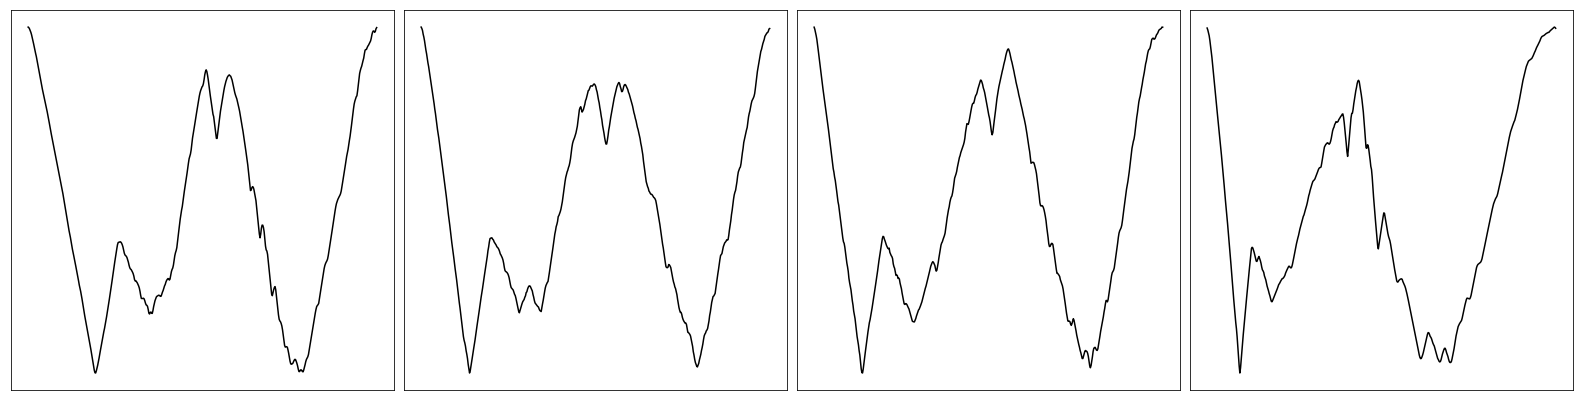

In [178]:
# Plot data points and transformations

x = np.linspace(0,1,ts_length)

# Sample a data points
i = random.randint(0, class_size-1)
#data_point_1 = X_train_class[i]

i = random.randint(0, class_size-1)
#data_point_2 = X_train_class[i]

#data_point_3 = generate_new_data(sigma, B, X_train_class, N_step, N_p)

#data_point_4 = generate_new_data(sigma, B, X_train_class, N_step, N_p)


plot_color = "black"
if plot_color == "color":
    color_original = 'b'
    color_random = 'r'
else:
    color_original = 'k'
    color_random = 'k'


title_size = 20
plt.figure(figsize=(28, 7))

plt.subplot(143)
plt.plot(x, data_point_1, color=color_original, linewidth=1.5)
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.plot(x, data_point_2, color=color_original, linewidth=1.5)
plt.xticks([])
plt.yticks([])

plt.subplot(141)
plt.plot(x, data_point_3, color=color_random, linewidth=1.5)
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.plot(x, data_point_4, color=color_random, linewidth=1.5)
plt.xticks([])
plt.yticks([])
          
plt.subplots_adjust(wspace=0.025, hspace=0)

#plt.savefig(ds + "_generated_data_" + plot_color + ".eps", bbox_inches='tight')
plt.show()

## Histogram for difference in performance

In [73]:
# Read previous performance results on UCR Archive
UCR_results = {}

lines = [line.rstrip('\n') for line in open('UCR_results.txt')]

for line in lines:
    ds,nn_ed,nn_dtw,mlp,fcn,resnet,cote,shape_dtw = line.split(",")
    UCR_results[ds] = ([nn_ed,nn_dtw,mlp,fcn,resnet,cote])

In [74]:
with open('1NN-DatAug_performance', 'rb') as f:
    perf_table = pickle.load(f)

In [75]:
with open('FCN-DatAug_performance', 'rb') as f:
    perf_table_net_fcn = pickle.load(f)

FCN_results = {}
    
for line in perf_table_net_fcn:
    ds,nn_ed,nn_dtw,mlp,fcn,fcn_aug,run_time = line
    FCN_results[ds] = ([nn_ed,nn_dtw,mlp,fcn,fcn_aug])

In [76]:
# Fetch 1NN-DTW and FCN-DatAug performance
data_sets = perf_table[1:, 0]
nn_dtw = np.array([])
fcn_aug = np.array([])

for ds in data_sets:
    if ds in ['CinC_ECG_torso','HandOutlines']:
        continue
    nn_dtw = np.append(nn_dtw,FCN_results[ds][1])
    fcn_aug = np.append(fcn_aug,FCN_results[ds][4])

# Compute differences in performance
perf_diff2 = nn_dtw.astype(np.float) - fcn_aug.astype(np.float)

In [77]:
# Fetch 1NN-DTW and 1NN-DatAug performance
print(perf_table)
perf_table = perf_table[:, [2,7]]

# Remove rows with missing data
perf_table = perf_table[np.where(perf_table[:,1] != '/')[0]]

# Compute differences in performance
perf_diff = perf_table[1:, 0].astype(np.float) - perf_table[1:, 1].astype(np.float)

[['Data set' '1NN-ED' '1NN-DTW' 'MLP' 'FCN' 'ResNet' 'COTE' '1NN-DatAug'
  'Run time']
 ['50words' '0.369' '0.310' '0.288' '0.321' '0.273' '0.191'
  '0.36923076923076925' '0.051604270935058594']
 ['Adiac' '0.389' '0.396' '0.248' '0.143' '0.174' '0.233'
  '0.38874680306905374' '3.186532967723906']
 ['ArrowHead' '0.200' '0.297' '0.177' '0.120' '0.183' '/'
  '0.19428571428571428' '3.6232444029301405']
 ['Beef' '0.333' '0.367' '0.167' '0.25' '0.233' '0.133'
  '0.33333333333333337' '3.3258811058476567']
 ['BeetleFly' '0.250' '0.300' '0.150' '0.050' '0.200' '/' '0.4'
  '7.084510922897607']
 ['BirdChicken' '0.450' '0.250' '0.200' '0.050' '0.100' '/'
  '0.19999999999999996' '5.899353120010346']
 ['CBF' '0.148' '0.003' '0.14' '0' '0.006' '0.001' '0.004444444444444473'
  '19.557911437936127']
 ['Car' '0.267' '0.267' '0.167' '0.083' '0.067' '/' '0.33333333333333337'
  '4.905198831111193']
 ['ChlorineConcentration' '0.35' '0.352' '0.128' '0.157' '0.172' '0.314'
  '0.3526041666666667' '5.4865281069

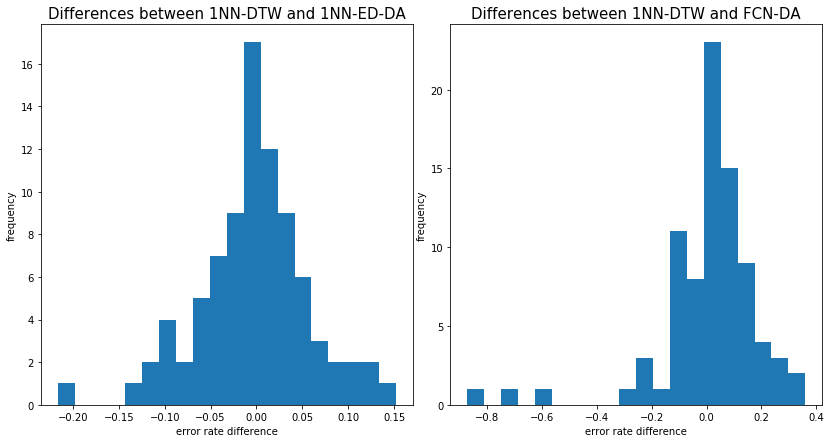

In [83]:
# Plot histogram of differences
title_size = 15
plt.figure(figsize=(14,7))

plt.subplot(121)
plt.hist(perf_diff, bins=20, histtype='bar')
plt.xlabel('error rate difference')
plt.ylabel('frequency')
plt.title('Differences between 1NN-DTW and 1NN-ED-DA', fontsize=title_size)

plt.subplot(122)
plt.hist(perf_diff2, bins=20, histtype='bar')
plt.xlabel('error rate difference')
plt.ylabel('frequency')
plt.title('Differences between 1NN-DTW and FCN-DA', fontsize=title_size)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig("hist_perf_diff.eps", bbox_inches='tight')
plt.show()

In [84]:
len(np.where(perf_diff2 >= 0)[0])

53

## Performance tables

In [24]:
with open('ResNet-DatAug_performance_1500', 'rb') as f:
    perf_table_net = pickle.load(f)

In [25]:
for line in perf_table_net:
    (ds,nn_ed,nn_dtw,mlp,fcn,resnet_aug,run_time) = line
    print(ds + ' & & ' + resnet_aug + ' \\\\\n')

BirdChicken & & 0.09999999999999998 \\

Data set & & ResNet-DatAug \\

DistalPhalanxTW & & 0.26249999999999996 \\



In [20]:
print(perf_table_net)

[['BirdChicken' '0.450' '0.250' '0.200' '0.050' '0.050000000000000044'
  '3578.697722735']
 ['Data set' '1NN-ED' '1NN-DTW' 'MLP' 'FCN' 'ResNet-DatAug'
  'Run time ResNet-DatAug']
 ['DistalPhalanxTW' '0.273' '0.290' '0.253' '0.210' '0.26'
  '487.06200801099476']
 ['Herring' '0.484' '0.469' '0.313' '0.297' '0.453125' '3577.5542002960065']
 ['InsectWingbeatSound' '0.438' '0.645' '0.369' '0.598'
  '0.6505050505050505' '1714.4261694000015']
 ['Phoneme' '0.891' '0.772' '0.902' '0.655' '0.8871308016877637'
  '18.721875814997475']
 ['RefrigerationDevices' '0.605' '0.536' '0.629' '0.467'
  '0.45866666666666667' '5091.954360535994']]


## Presentation plots

In [110]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

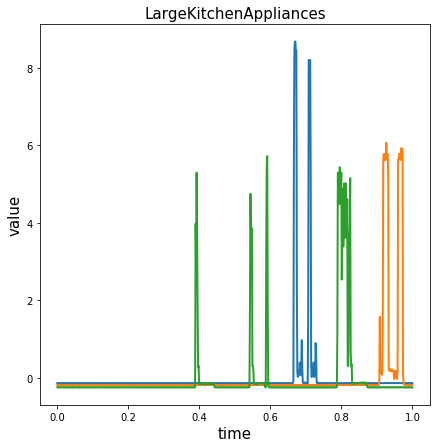

In [123]:
title_size = 15

plt.figure(figsize=(7, 7))
plt.plot(np.linspace(0,1,ts_length), X_train[4], linewidth=2)
plt.plot(np.linspace(0,1,ts_length), X_train[163], linewidth=2)
plt.plot(np.linspace(0,1,ts_length), X_train[302], linewidth=2)
plt.xlabel('time', fontsize=title_size)
plt.ylabel('value', fontsize=title_size)
plt.xticks(fontsize=title_size-5)
plt.yticks(fontsize=title_size-5)
plt.title(ds, fontsize=title_size)

#plt.savefig(ds + "_signals.eps", bbox_inches='tight')
plt.show()